# <span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Zeunerstraße 38, 01069 Dresden, Germany
</span>

---

# Condition Monitoring of Drive Trains by Data Fusion of Acoustic Emission and Vibration Sensors

### Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Dirk Mayer, Christian Schmidt, Samuel Klein and Hans-Georg Herrmann

---

## Notebook *DataExploration_03_VB_AE_Timeseries*


The diagrams show the time signals for each series of measurements for the vibrations (*blue*) and the acoustic emissions (*red*). In the case of vibrations, all samples are recorded. For acoustic emissions, one frame (out of approx. 20 per second) is selected and displayed for each measurement second. The time signals are therefore not continuous. The aim is to give a rough impression of the vibration behavior for all measurement series and all rotational speed ranges. 

---

<span style="color:gray">
Version: 1.0.1 (May 31, 2021) <br>
Authors: André Schneider, Oliver Mey 
 </span>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import colorcet as cc
import urllib, json
from scipy.signal.signaltools import wiener
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from glob import glob
from itertools import chain

sns.set(rc={'figure.figsize':(16, 8)})

In [2]:
project = 'SkaliSens_07'
experiment = 'DataExploration_03'
approach = 'VB_AE_TimeSeries'
revision = '$Id$'

## Configuration

The *path* must specify the directory into which the Fordatis data set was downloaded and unpacked. With *mask* a subset of measurements can be configured using a regular expression (e.g. all measurements starting with *1*).

In [3]:
path = 'fordatis'
masks = ['1*']
labels = ['None', 'Inner', 'Outer', 'Balls']
sensors = ['vb', 'ae']
frame = 12
frequencies = [8192.0, 390625.0]
crop = [[10.0, 2000.0], [512.0, 50.0e3]]

In [4]:
files = [sorted(glob(path + '/data/' + mask)) for mask in masks]
files = list(chain(*files))
measurements = [os.path.basename(str(file)) for file in files]
f_vb = np.linspace(0.0, frequencies[0]/2,4097)
f_ae = np.linspace(0.0, frequencies[1]/2,4001)
i1 = np.argwhere(f_vb >= crop[0][0])[0][0]
i2 = np.argwhere(f_vb <= crop[0][1])[-1][0]
inputs_vb = i2 - i1 + 1
crop_vb = [slice(None, None),slice(i1, i2)]
i1 = np.argwhere(f_ae >= crop[1][0])[0][0]
i2 = np.argwhere(f_ae <= crop[1][1])[-1][0]
inputs_ae = i2 - i1 + 1
crop_ae = [slice(None, None),slice(i1, i2)]
descriptors = [pd.read_json(path + '/measurements/' + measurement + '.json') for measurement in measurements]
usecases = [labels.index(descriptor.loc['usecasegroup', 'measurement']) for descriptor in descriptors]

## Function definitions

In [5]:
def load_samples(path, measurement, sensor):
    samples = pd.read_csv(path + '/data/' + measurement + '/' + sensor + '.csv', 
                   parse_dates=[0], index_col=0, sep=' ', header=None)
    samples.index = samples.index.values.astype('datetime64[us]')
    return samples

def filter_frames(X1, X2):
    X2_ = X2[X2.index.ceil('s').isin(X1.index)]
    X1_ = X1[X1.index.isin(X2_.index.ceil('s'))]
    return X1_, X2_

def select_frames(X, frame=0):
    x = X[1].groupby(X[1].index.ceil('s')).nth([0, frame])
    x = x.groupby(x.index.ceil('s')).last()
    return X[0], x

def prepare_frames(vb, ae, frame=0):
    X = [filter_frames(vb[i], ae[i]) for i in range(len(vb))]
    X = [select_frames(X[i], frame=frame) for i in range(len(X))]
    X_vb = [X[i][0] for i in range(len(X))]
    X_ae = [X[i][1] for i in range(len(X))]
    return X_vb, X_ae

def load_frames():    
    X = [[load_samples(path, measurement, sensor) for measurement in measurements] for sensor in sensors]
    X_vb, X_ae = prepare_frames(X[0], X[1], frame=frame)
    return X_vb, X_ae

def plot(X, measurement, title='', xlabel='', ylabel='', alpha=0.4, color='b', ylim=[-0.5,0.5]):
    x = pd.DataFrame(X.to_numpy().reshape(-1))
    x.plot(alpha=alpha, color=color, ylim=ylim, figsize=(16,4), legend=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title + ' ' + measurement, fontweight='bold')
    plt.show()
    return

## Loading and preprocessing of data

In [6]:
X_vb, X_ae = load_frames()

## Plotting of Vibration timeseries

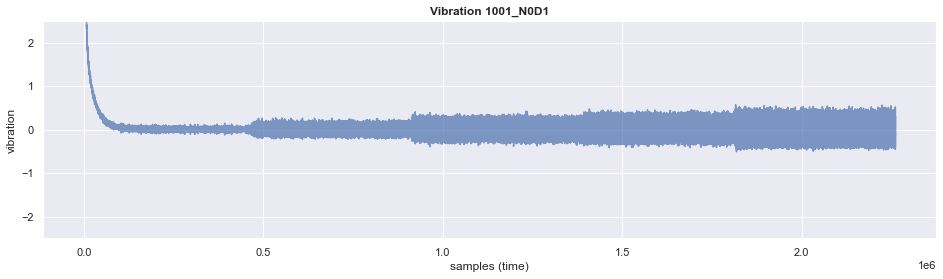

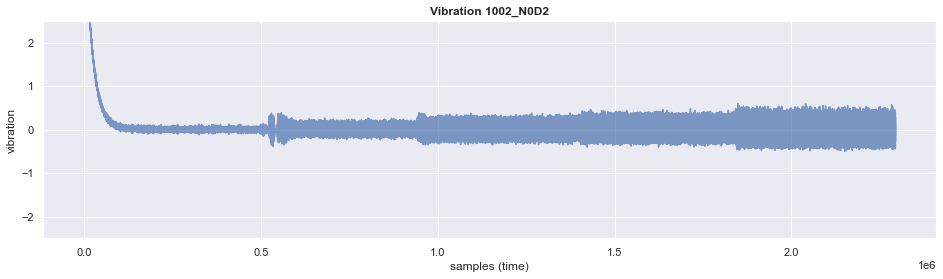

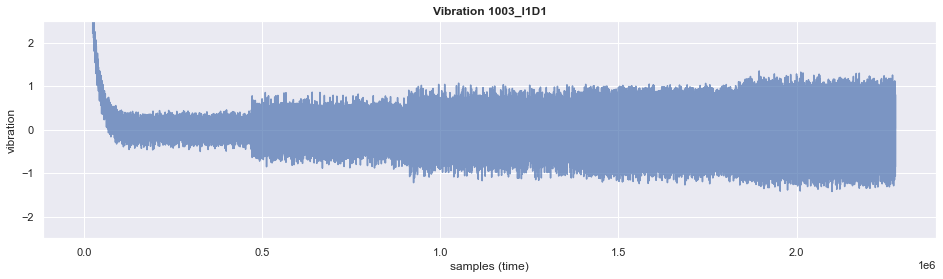

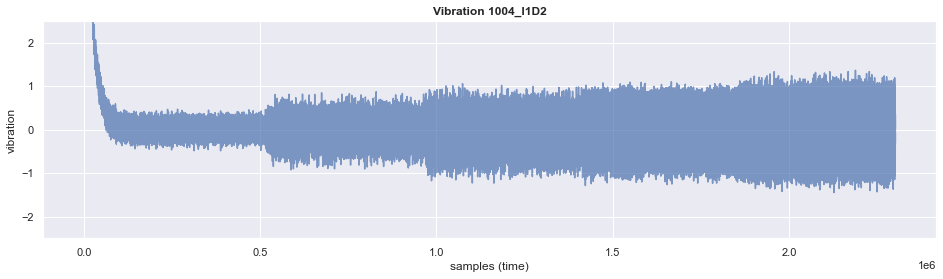

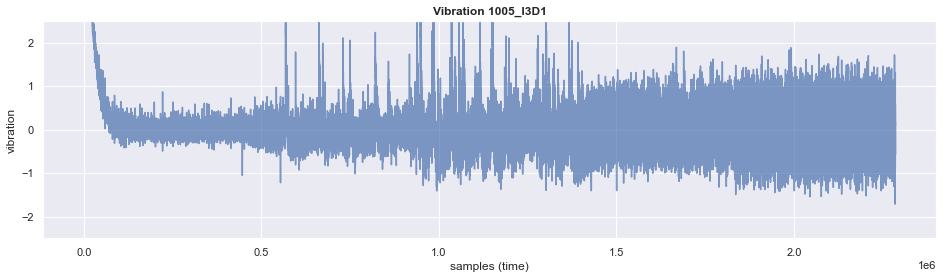

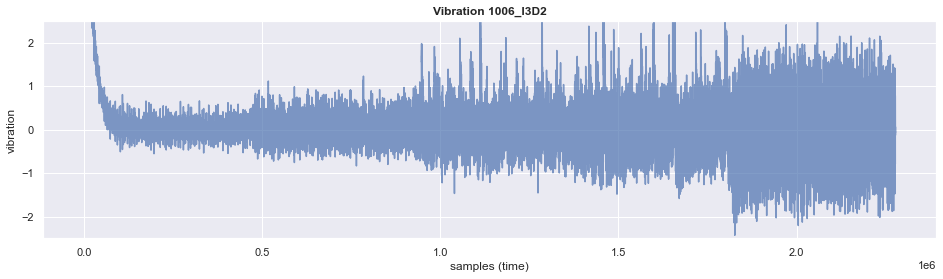

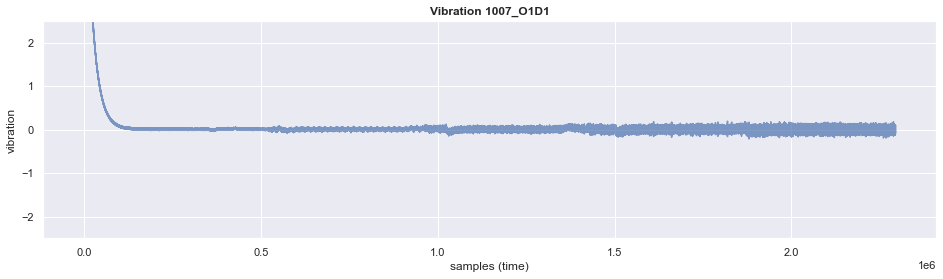

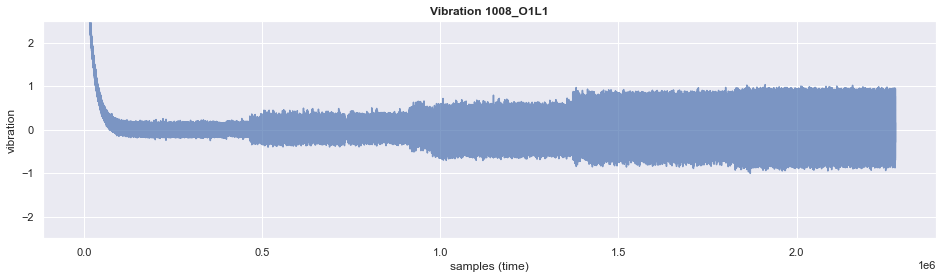

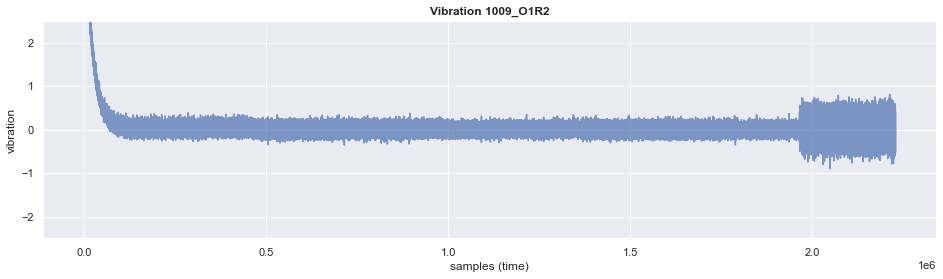

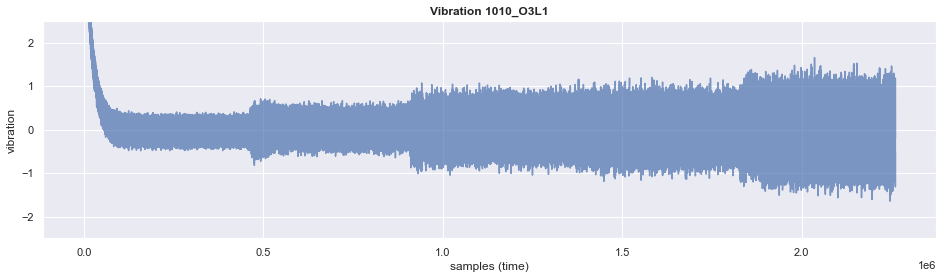

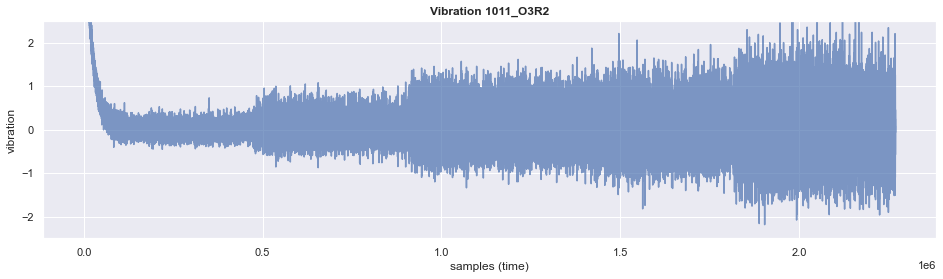

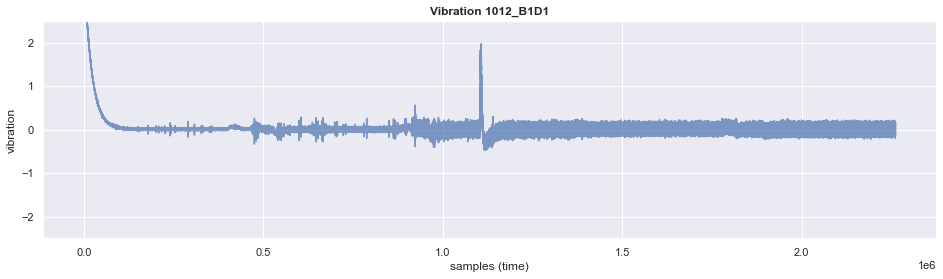

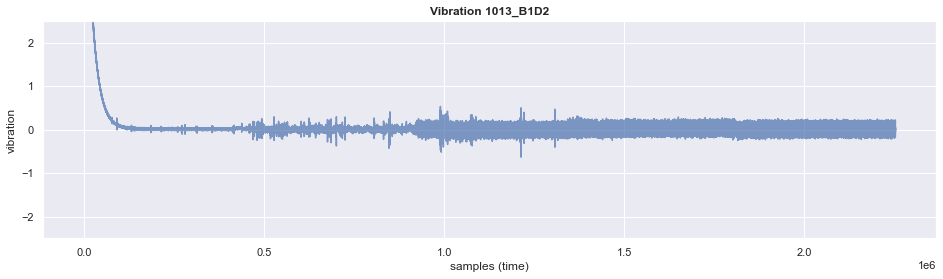

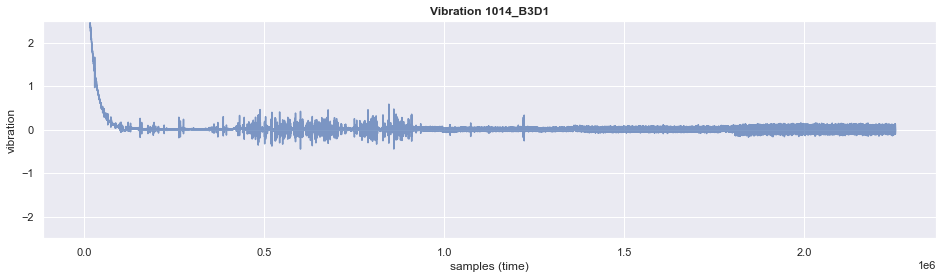

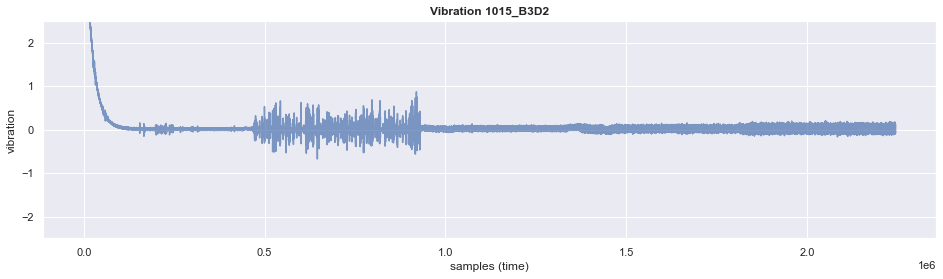

In [7]:
_ = [plot(x, m, title='Vibration', xlabel='samples (time)', ylabel='vibration', alpha=0.7, color='b', ylim=[-2.5,2.5]) 
     for x,m in zip(X_vb, measurements)]

## Plotting of Acoustic Emission timeseries

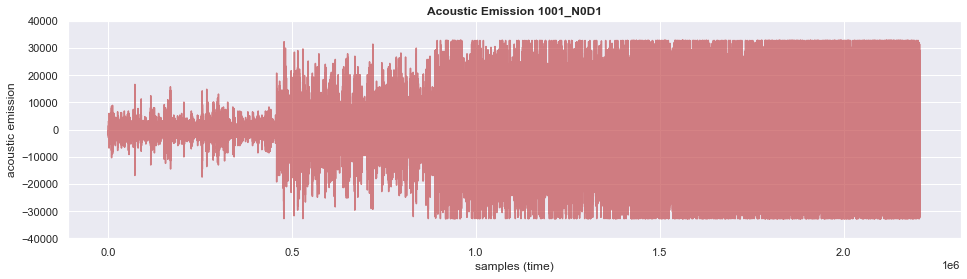

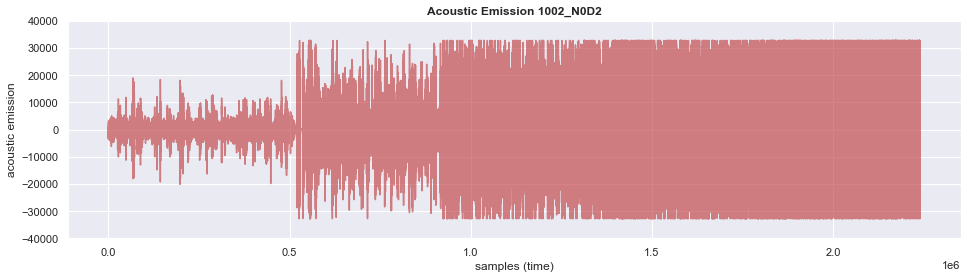

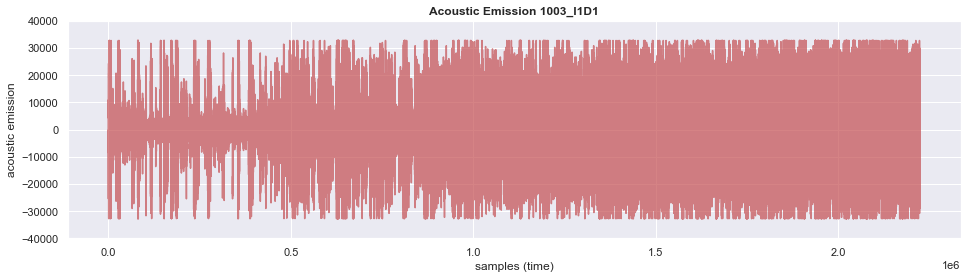

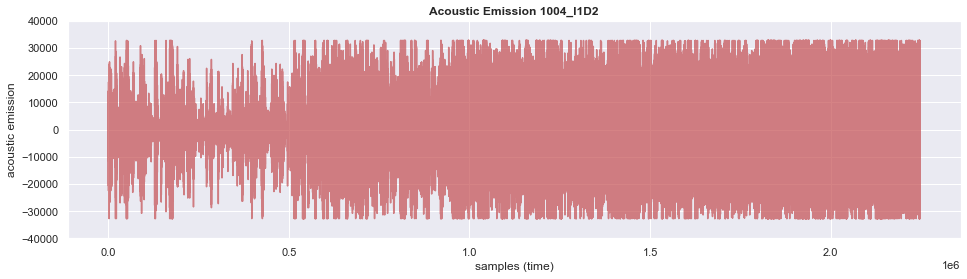

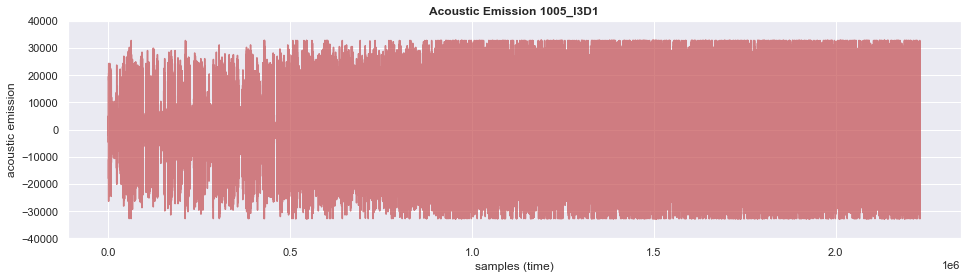

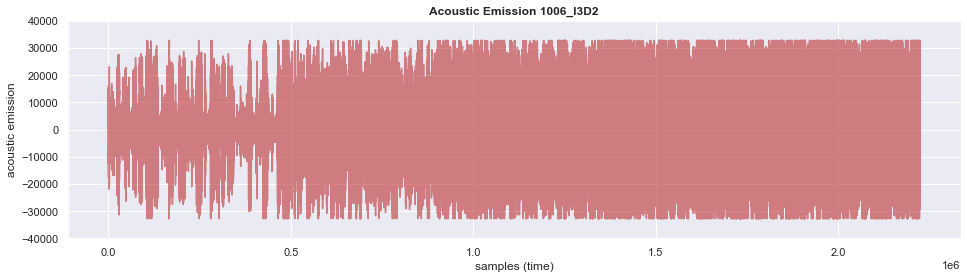

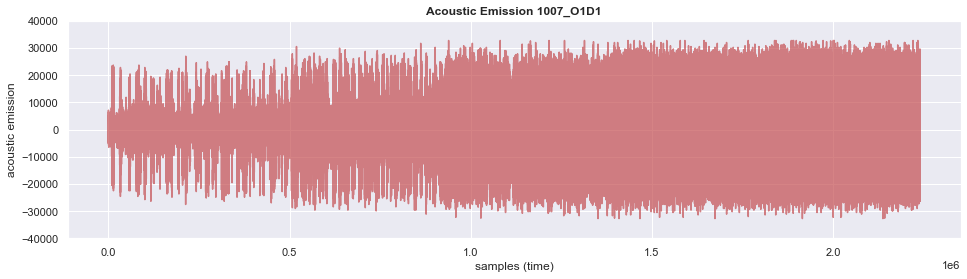

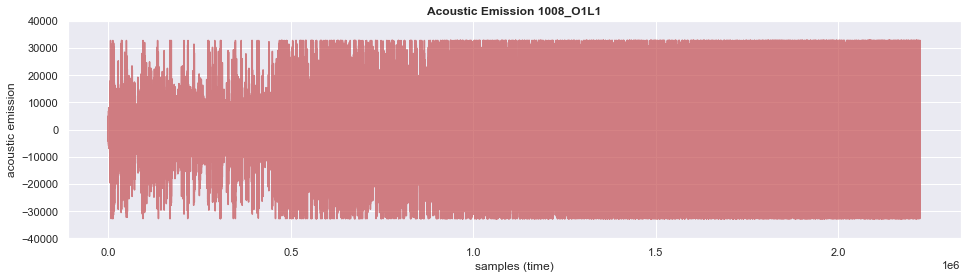

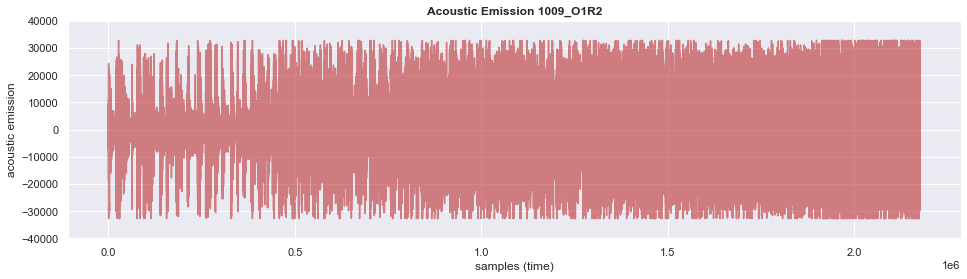

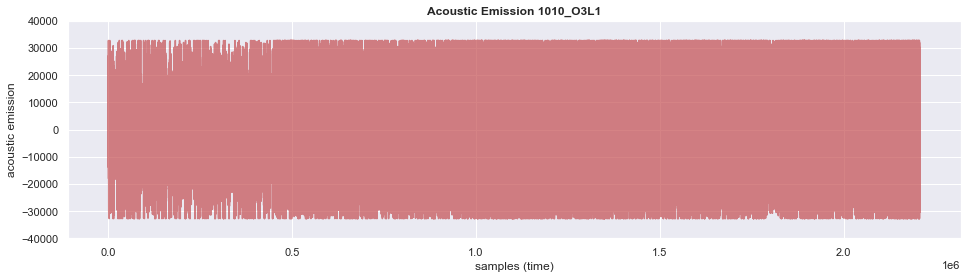

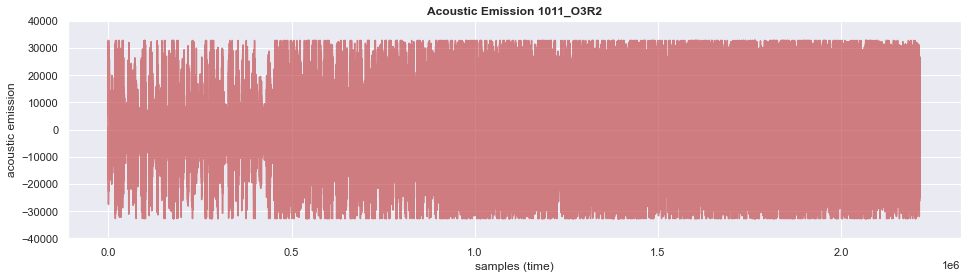

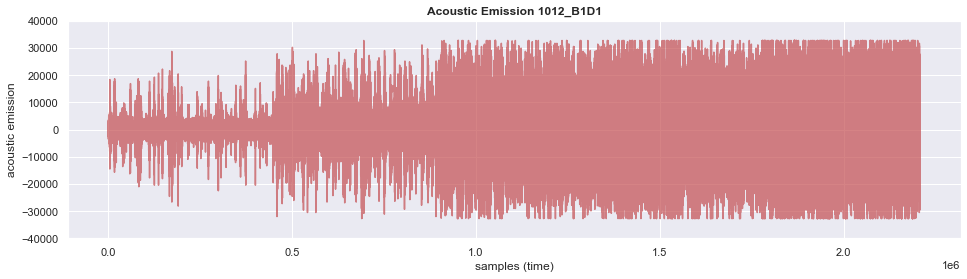

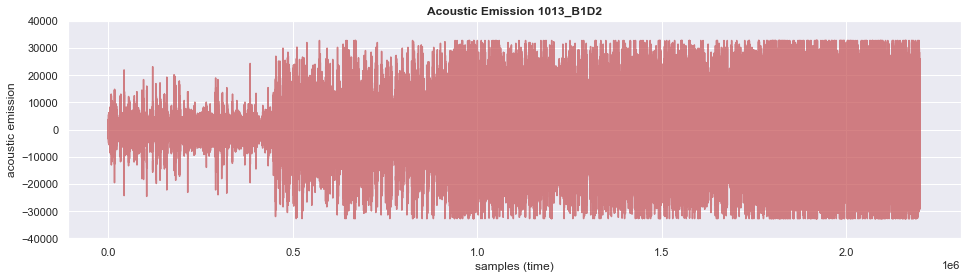

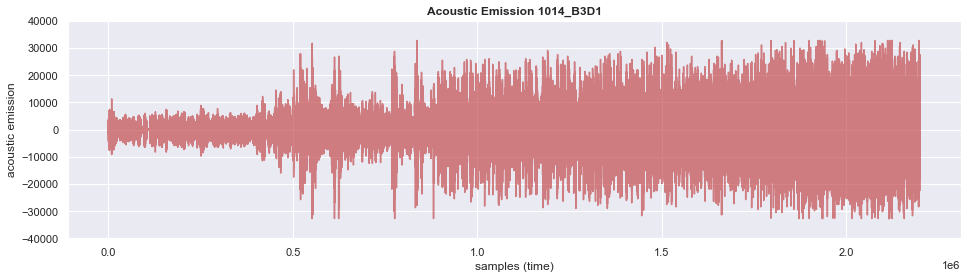

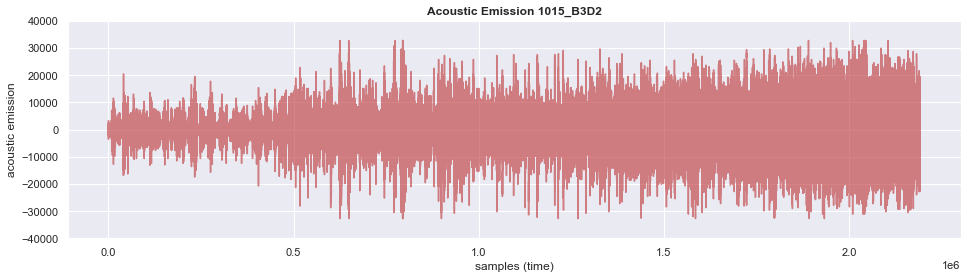

In [8]:
_ = [plot(x, m, title='Acoustic Emission', xlabel='samples (time)', ylabel='acoustic emission', alpha=0.7, color='r', ylim=[-4e4,4e4]) 
     for x,m in zip(X_ae, measurements)]